# Imports

In [13]:
import itertools
import math
import pandas as pd
import json
import os
import glob

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import screed
import sklearn

%matplotlib inline

In [2]:
def describe(df):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    print('--- Random subset ---')
    display(df.sample(5))

# Get gold standard reading frames

## Read gold standard reading frame file

In [3]:
parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/true_reading_frames.parquet'

true_coding_frame = pd.read_parquet(parquet)
# Create just a series (single column) from this
true_coding_frame = true_coding_frame['is_coding']
true_coding_frame.head()

read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1      True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1    False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2    False
Name: is_coding, dtype: bool

# Read concatenated scores for metrics

## Human

In [4]:
%%time


has_stop_codon = 'Translation frame has stop codon(s)'


parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/coding_scores.parquet'
human_scores_for_metrics = pd.read_parquet(parquet, use_threads=True)
human_scores_for_metrics = human_scores_for_metrics.query('(category == "Non-coding") or (category == "Coding")')

# human_scores_for_metrics = human_scores_for_metrics.set_index('read_id_frame')
print(human_scores_for_metrics.shape)
human_scores_for_metrics.head()

(43973736, 12)
CPU times: user 4min 43s, sys: 2min 20s, total: 7min 4s
Wall time: 4min 30s


### Make sure none of the jaccard in peptide db is null

In [5]:
human_scores_for_metrics.category.value_counts()

Non-coding    30860350
Coding        13113386
Name: category, dtype: int64

In [6]:
human_scores_for_metrics.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.888889,36.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,14,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.846154,26.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,24,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.875000,32.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,18,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.789474,19.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.840000,25.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,25,human,False,sp|O43295|ENSP00000373347,O43295


## Mouse

In [7]:
%%time

parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet'
mouse_scores_for_metrics = pd.read_parquet(parquet, use_threads=True)
# mouse_scores_for_metrics = mouse_scores_for_metrics.set_index('read_id_frame')
mouse_scores_for_metrics = mouse_scores_for_metrics.query('(category == "Non-coding") or (category == "Coding")')
print(mouse_scores_for_metrics.shape)
mouse_scores_for_metrics.head()

(43973736, 12)
CPU times: user 3min 3s, sys: 1min 52s, total: 4min 55s
Wall time: 2min 29s


### Make sure none of the jaccard in peptide db is null

In [8]:
mouse_scores_for_metrics.jaccard_in_peptide_db.isnull().sum()

0

In [9]:
mouse_scores_for_metrics.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.0,36.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,14,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.0,26.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,24,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.0,32.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,18,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.0,19.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.0,25.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,25,mouse,False,sp|O43295|ENSP00000373347,O43295


## Combine mouse and human to compute scores on one

In [10]:
combined_scores = pd.concat([human_scores_for_metrics, mouse_scores_for_metrics])
combined_scores = combined_scores.sort_index()
print(combined_scores.shape)
combined_scores.head()

(87947472, 12)


,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.888889,36.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,14,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.000000,27.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,23,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.000000,35.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,15,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.000000,37.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,13,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-3,read100001/sp|O43295|ENSP00000373347;mate1:128...,0.000000,31.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,19,mouse,False,sp|O43295|ENSP00000373347,O43295


# Compute accuracy/F1 scores

## Human F1, accuracy, etc...scores

In [14]:
%%time

score_names = 'accuracy', 'f1', 'jaccard', 'precision', 'recall',  


metrics = {
    'f1_score': sklearn.metrics.f1_score,
    'accuracy_score': sklearn.metrics.accuracy_score,
    'jaccard_score': sklearn.metrics.jaccard_score,
    'precision_score': sklearn.metrics.precision_score,
    'recall_score': sklearn.metrics.recall_score,
}

def score_coding_metrics(coding_results, true_coding_frame=true_coding_frame, metrics=metrics):

    dfs = []
    for score_name, scorer in tqdm(metrics.items()):
        print(f'score_name: {score_name}')
    #     scorer = sklearn.metrics.get_scorer(score_name)

        scores = coding_results.groupby(['species', 'alphabet', 'ksize']).is_coding.apply(
            lambda x: scorer(true_coding_frame[x.index], x))

        scores.name = 'score_value'
        scores_df = scores.reset_index()
        scores_df['score_name'] = score_name
        dfs.append(scores_df)
    metrics_df = pd.concat(dfs)
    return metrics_df

combined_metrics = score_coding_metrics(combined_scores)
print(combined_metrics.shape)
combined_metrics.head()

  0%|          | 0/5 [00:00<?, ?it/s]

score_name: f1_score


 20%|██        | 1/5 [02:36<10:27, 156.89s/it]

score_name: accuracy_score


 40%|████      | 2/5 [04:30<06:45, 135.05s/it]

score_name: jaccard_score


 60%|██████    | 3/5 [06:45<04:30, 135.12s/it]

score_name: precision_score


 80%|████████  | 4/5 [09:01<02:15, 135.30s/it]

score_name: recall_score


100%|██████████| 5/5 [11:16<00:00, 135.27s/it]

(460, 5)
CPU times: user 10min 34s, sys: 40.9 s, total: 11min 15s
Wall time: 11min 16s


### Write combined metrics to csv!!!

In [15]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/human_mouse__coding_scores_metrics.csv'
combined_metrics.to_csv(csv, index=False)

In [20]:
combined_metrics.head()

,species,alphabet,ksize,score_value,score_name
0,human,dayhoff,9,0.731649,f1_score
1,human,dayhoff,10,0.799987,f1_score
2,human,dayhoff,11,0.803280,f1_score
3,human,dayhoff,12,0.798536,f1_score
4,human,dayhoff,13,0.796864,f1_score


### Plot metrics

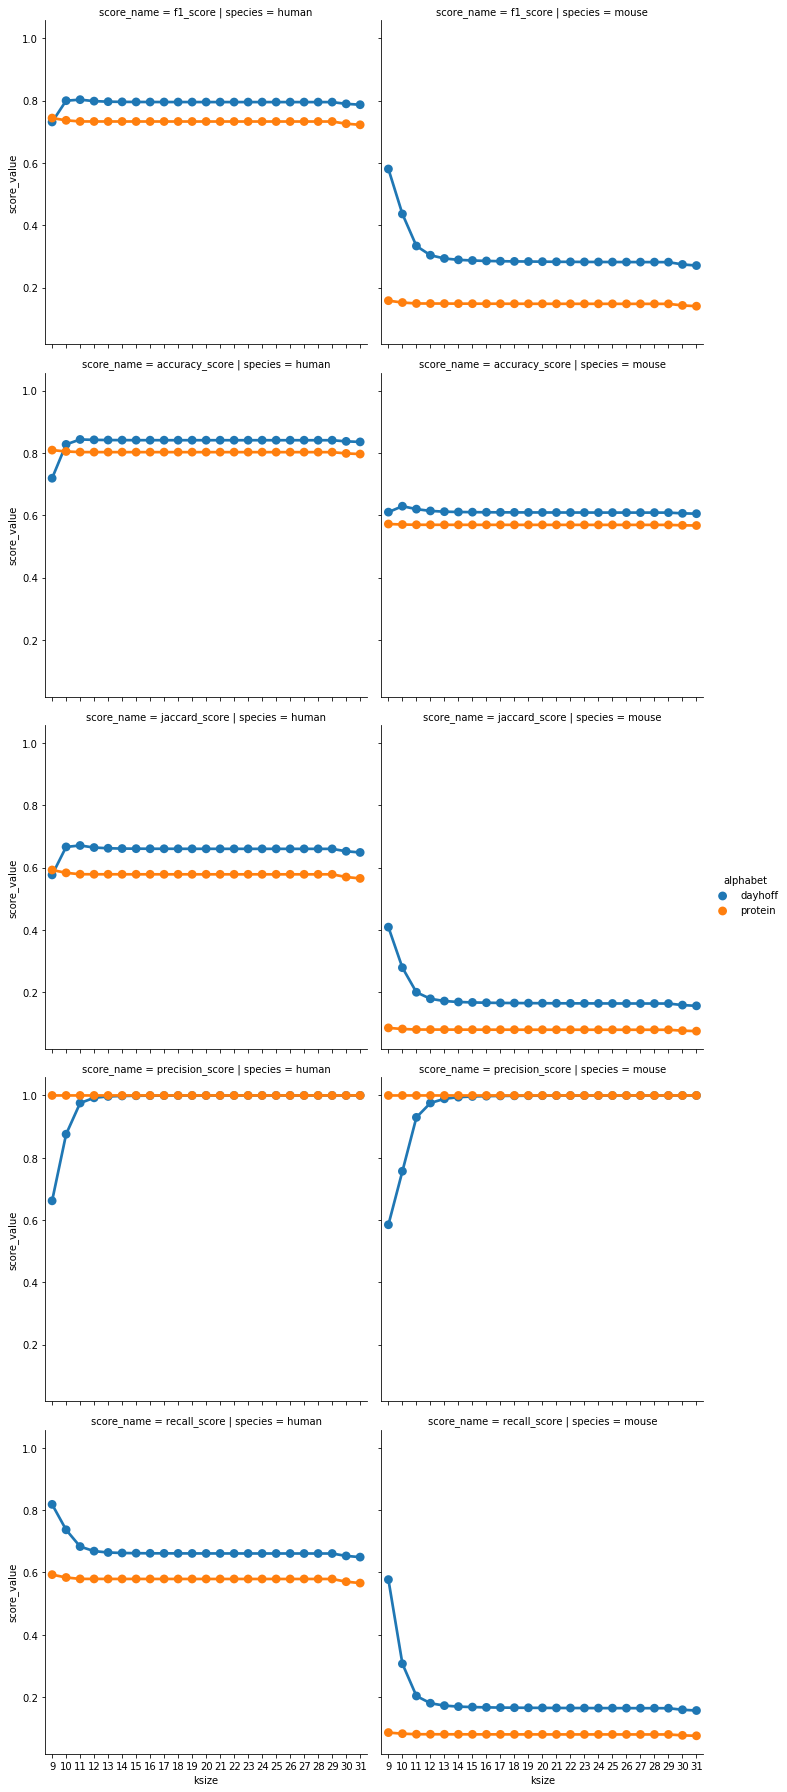

In [19]:
sns.catplot(x='ksize', y='score_value', hue='alphabet', row='score_name', col='species',
            data=combined_metrics, kind='point')

## Compute ROC AUC

### Human

In [21]:
%%time

def compute_roc_auc(coding_results, true_coding_frame=true_coding_frame):
    scores = coding_results.groupby(['species', 'alphabet', 'ksize']).jaccard_in_peptide_db.apply(
        lambda x: sklearn.metrics.roc_auc_score(true_coding_frame[x.index], x))

    scores.name = 'score_value'
    scores_df = scores.reset_index()
    scores_df['score_name'] = 'roc_auc'

    return scores_df

combined_roc_auc_score = compute_roc_auc(combined_scores)
combined_roc_auc_score.head()

CPU times: user 2min 1s, sys: 4.53 s, total: 2min 5s
Wall time: 2min 5s



## Compute ROC Curve

### Human

In [38]:
%%time

def _get_roc_curve_df(y_true, y_score):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    df.index.name = 'threshold_i'
    return df



def compute_roc_curve(coding_results, true_coding_frame=true_coding_frame):
    curve_df = coding_results.groupby(['species', 'alphabet', 'ksize']).jaccard_in_peptide_db.apply(
        lambda x: _get_roc_curve_df(true_coding_frame[x.index], x))

    curve_df['score_name'] = 'roc_auc'

    return curve_df

combined_roc_curve = compute_roc_curve(combined_scores)
combined_roc_curve = combined_roc_curve.reset_index()
describe(combined_roc_curve)

(17994, 8)
--- First 5 entries ---


,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name
0,human,dayhoff,9,0,0.000000,0.000000,2.00000,roc_auc
1,human,dayhoff,9,1,0.218426,0.764102,1.00000,roc_auc
2,human,dayhoff,9,2,0.243622,0.774810,0.97619,roc_auc
3,human,dayhoff,9,3,0.297313,0.795568,0.97561,roc_auc
4,human,dayhoff,9,4,0.299702,0.795763,0.97500,roc_auc


--- Random subset ---


,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name
11475,mouse,dayhoff,14,410,0.350662,0.810907,0.030303,roc_auc
13265,mouse,dayhoff,20,168,0.003429,0.433855,0.320000,roc_auc
12895,mouse,dayhoff,19,64,0.000464,0.226919,0.730769,roc_auc
12941,mouse,dayhoff,19,110,0.001099,0.286313,0.565217,roc_auc
13011,mouse,dayhoff,19,180,0.004951,0.450647,0.322581,roc_auc


CPU times: user 2min 31s, sys: 5.3 s, total: 2min 36s
Wall time: 2min 36s


In [39]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/human_mouse__coding_scores_roc_curve.csv'
combined_roc_curve.to_csv(csv, index=False)

# Concatenate ROC AUC with other metrics

## Combine non-curve sscores

In [23]:
concatenated_metrics = pd.concat([combined_roc_auc_score, combined_metrics], ignore_index=True)
describe(concatenated_metrics)

(552, 5)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name
0,human,dayhoff,9,0.783296,roc_auc
1,human,dayhoff,10,0.895445,roc_auc
2,human,dayhoff,11,0.958837,roc_auc
3,human,dayhoff,12,0.981756,roc_auc
4,human,dayhoff,13,0.989993,roc_auc


--- Random subset ---


,species,alphabet,ksize,score_value,score_name
330,mouse,dayhoff,17,0.166107,jaccard_score
383,human,dayhoff,24,0.999679,precision_score
8,human,dayhoff,17,0.996602,roc_auc
410,human,protein,28,0.999749,precision_score
387,human,dayhoff,28,0.999706,precision_score


In [24]:
concatenated_metrics.score_name.value_counts()

precision_score    92
f1_score           92
accuracy_score     92
recall_score       92
jaccard_score      92
roc_auc            92
Name: score_name, dtype: int64

### Write combined metrics to csv!!!

In [25]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/human_mouse__coding_scores_metrics_concatenated.csv'
concatenated_metrics.to_csv(csv, index=False)

## Which molecule, ksize maximizes each metric?

In [29]:
combined_roc_auc = concatenated_metrics.query('score_name == "roc_auc"')

In [30]:
concatenated_metrics.loc[concatenated_metrics.groupby(['species', 'score_name',]).score_value.idxmax()]

,species,alphabet,ksize,score_value,score_name
186,human,dayhoff,11,0.843484,accuracy_score
94,human,dayhoff,11,0.803280,f1_score
278,human,dayhoff,11,0.671235,jaccard_score
413,human,protein,31,0.999846,precision_score
460,human,dayhoff,9,0.818209,recall_score
25,human,protein,11,0.998840,roc_auc
231,mouse,dayhoff,10,0.629346,accuracy_score
138,mouse,dayhoff,9,0.580812,f1_score
322,mouse,dayhoff,9,0.409256,jaccard_score
459,mouse,protein,31,0.999793,precision_score


In [31]:
combined_roc_auc.loc[combined_roc_auc.groupby(['species', 'score_name',]).score_value.idxmax()]

,species,alphabet,ksize,score_value,score_name
25,human,protein,11,0.998840,roc_auc
69,mouse,protein,9,0.891089,roc_auc


In [40]:
combined_roc_curve.query('(species == "human") & (alphabet == "protein") & (ksize == 11)')

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name
5709,human,protein,9,0,0.000000,0.000000,2.000000,roc_auc
5710,human,protein,9,1,0.000077,0.566046,1.000000,roc_auc
5711,human,protein,9,2,0.000126,0.570474,0.976190,roc_auc
5712,human,protein,9,3,0.000126,0.579210,0.975610,roc_auc
5713,human,protein,9,4,0.000126,0.579232,0.975000,roc_auc
5714,human,protein,9,5,0.000130,0.579273,0.973684,roc_auc
5715,human,protein,9,6,0.000130,0.579286,0.972973,roc_auc
5716,human,protein,9,7,0.000130,0.579293,0.972222,roc_auc
5717,human,protein,9,8,0.000130,0.579299,0.969697,roc_auc
5718,human,protein,9,9,0.000130,0.579304,0.968750,roc_auc


In [41]:
combined_roc_curve.query('(species == "mouse") & (alphabet == "protein") & (ksize == 9)')

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name
14753,mouse,protein,9,0,0.000000,0.000000,2.000000,roc_auc
14754,mouse,protein,9,1,0.000014,0.076493,1.000000,roc_auc
14755,mouse,protein,9,2,0.000022,0.077964,0.976190,roc_auc
14756,mouse,protein,9,3,0.000022,0.080973,0.975610,roc_auc
14757,mouse,protein,9,4,0.000022,0.080979,0.975000,roc_auc
14758,mouse,protein,9,5,0.000022,0.080988,0.974359,roc_auc
14759,mouse,protein,9,6,0.000022,0.080991,0.973684,roc_auc
14760,mouse,protein,9,7,0.000022,0.080995,0.972973,roc_auc
14761,mouse,protein,9,8,0.000022,0.080999,0.971429,roc_auc
14762,mouse,protein,9,9,0.000022,0.081004,0.970588,roc_auc


In [51]:
combined_roc_curve.query('(species == "mouse") & (alphabet == "dayhoff") & (ksize == 16)')

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name
11855,mouse,dayhoff,16,0,0.000000,0.000000,2.000000,roc_auc
11856,mouse,dayhoff,16,1,0.000275,0.159011,1.000000,roc_auc
11857,mouse,dayhoff,16,2,0.000297,0.161537,0.971429,roc_auc
11858,mouse,dayhoff,16,3,0.000315,0.166710,0.970588,roc_auc
11859,mouse,dayhoff,16,4,0.000321,0.166726,0.969697,roc_auc
11860,mouse,dayhoff,16,5,0.000342,0.166750,0.968750,roc_auc
11861,mouse,dayhoff,16,6,0.000346,0.166752,0.967742,roc_auc
11862,mouse,dayhoff,16,7,0.000348,0.166757,0.966667,roc_auc
11863,mouse,dayhoff,16,8,0.000350,0.166764,0.965517,roc_auc
11864,mouse,dayhoff,16,9,0.000354,0.166775,0.964286,roc_auc


In [47]:
# combined_roc_curve.loc[[('human', 'protein', 11), ('mouse', 'protein', 9), ('mouse', 'dayhoff', 11)], :]

## Plot combined metrics

### Groupby score name, one by one

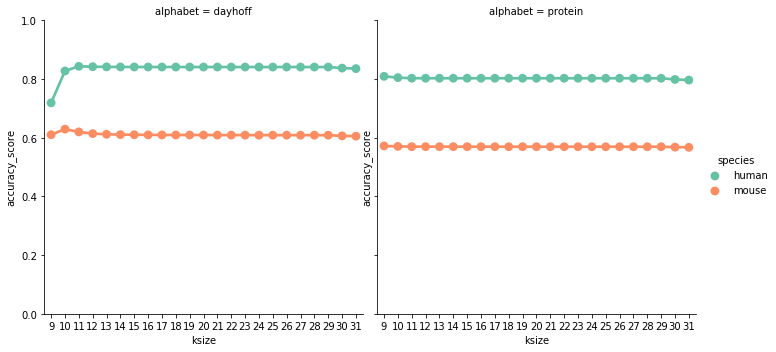

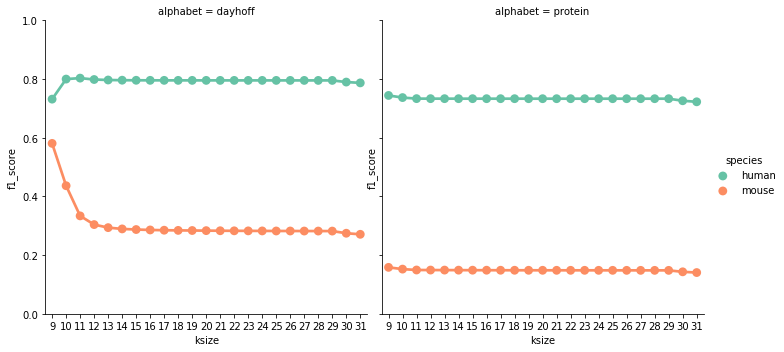

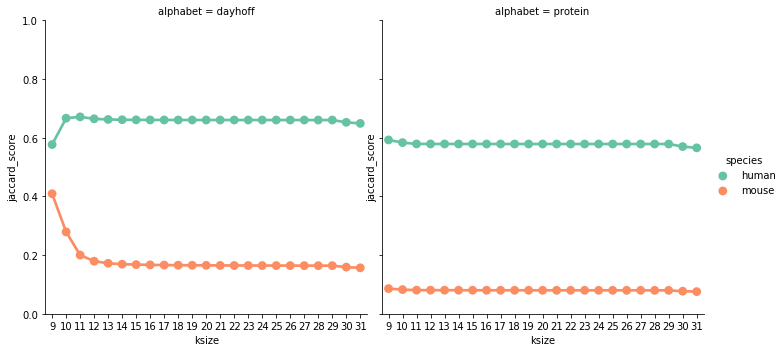

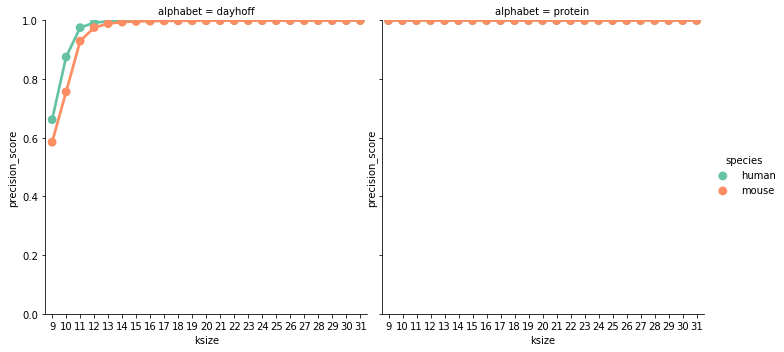

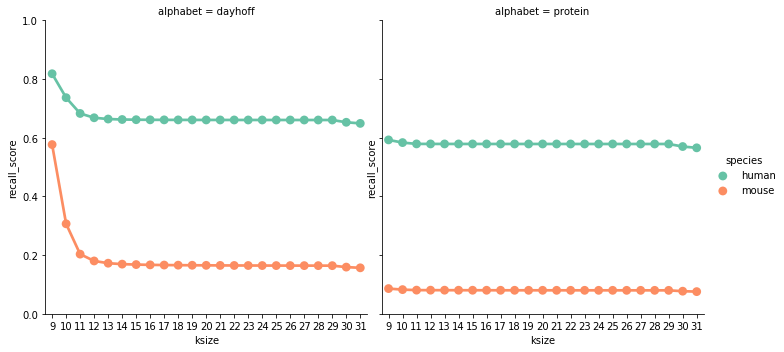

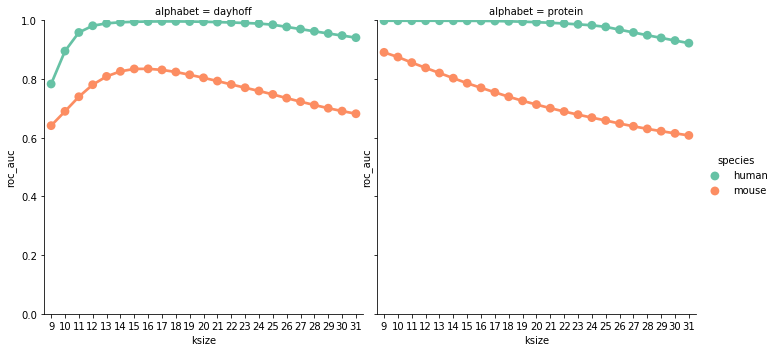

In [48]:
for score_name, df in concatenated_metrics.groupby('score_name'):
    g = sns.catplot(x='ksize', y='score_value', hue='species', col='alphabet', 
            data=df, kind='point', palette="Set2")
    g.set(ylabel=score_name, ylim=(0, 1))

## Just plot ROC AUC

In [ ]:
def plot_argmax(x, y, *args, **kwargs):
    idxmax = y.idxmax()
    plt.vlines(x[idxmax], 0, y.max(), linestyle='--', *args, **kwargs)
#     print('x:', x)
#     print('y:', y)
#     print('args:', args)
#     print('kwargs:', kwargs)
    pass

alphabet_order = ['protein', 'dayhoff']
g = sns.FacetGrid( hue='species', col='alphabet', col_order=alphabet_order,
        data=combined_roc_auc, palette="Set2", height=3, aspect=1.5)
g.map(sns.scatterplot, 'ksize', 'score_value')
g.add_legend()
g.map(plt.plot, 'ksize', 'score_value')
g.map(plot_argmax, 'ksize', 'score_value')
g.set(ylabel='ROC AUC', ylim=(0, 1))


### All in one grid

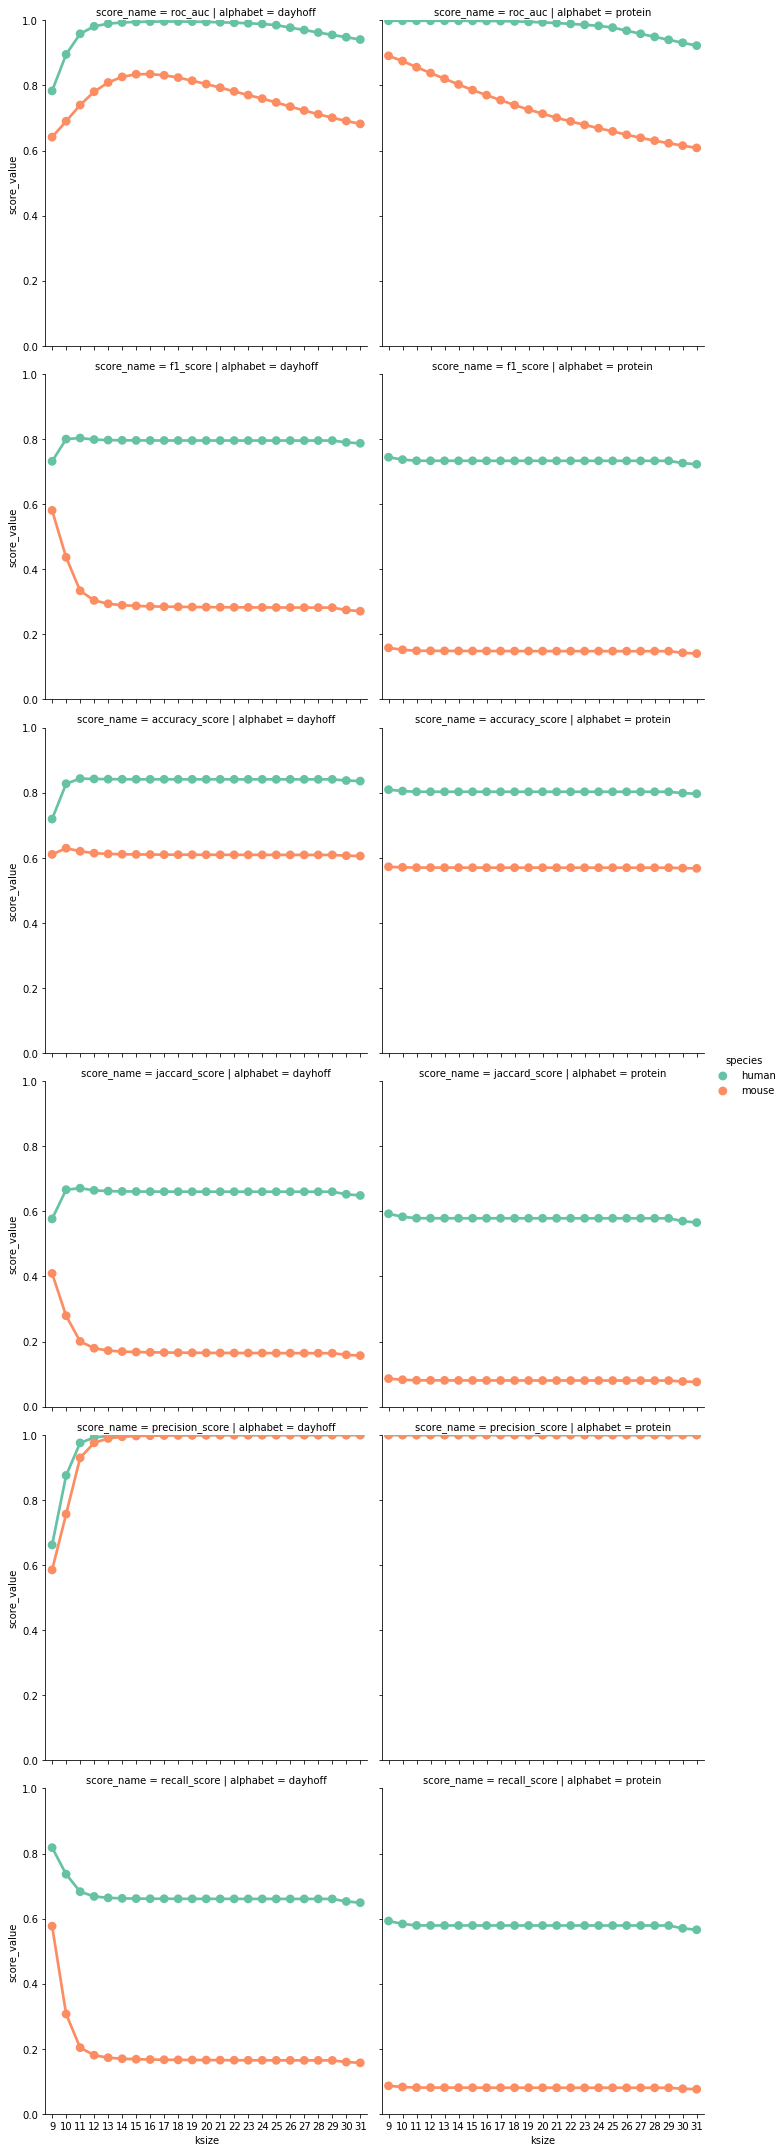

In [50]:
g = sns.catplot(x='ksize', y='score_value', hue='species', col='alphabet', 
        data=concatenated_metrics, kind='point', palette='Set2', row='score_name')
g.set(ylim=(0, 1 ))

## Plot ROC curves

### Plot combined roc curves

In [52]:

g = sns.FacetGrid(data=, col='alphabet', hue='ksize', palette='viridis', row='species')
g.map(plt.plot, 'fpr', 'tpr')

NameError: name 'combined_roc_curves' is not defined